# Evaluating Gene Correlations - First heart field

In [1]:
import numpy as np
import anndata
import pandas as pd
import matplotlib.pyplot as plt
import scvelo as scv
import datetime
import time
import os
import scanpy as sc
import sklearn.metrics
import seaborn as sns
from scipy import sparse
import scipy
import math


import matplotlib
from scipy.spatial import cKDTree
import sys
sys.path.append('/home/icb/manuel.gander/Reproducibility_TOME/Utils')

# Utils contains some functions I use a lot
import Utils

#sc.settings.verbosity = 0

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(11,6)})

In [2]:
Path="/home/icb/manuel.gander/Reproducibility_TOME/Data"

# Define time points
t=[3.5, 4.5, 5.25, 5.5]+[6.25+x/4 for x in range(0,10)]+[8.5]+[9.5+x for x in range(0,5)]
ts=[str(a) for a in [3.5, 4.5, 5.25, 5.5, 6.25]] + [str(a) for a in np.arange(6.5, 8.5, 0.25)] + ['8.5a', '8.5b']+ [str(a) for a in np.arange(9.5, 14.5, 1)]
ts=['E'+a for a in ts]

t2=[3.5, 4.5, 5.25, 5.5]+[6.25+x/4 for x in range(0,10)]+[9.5+x for x in range(0,5)]

# Growth of embryo:
#    - cells corresponds to the estimated total amount of cells in the embryo for each time point
#    - av_g corresponds to the average grwoth rate of the embryo at each specific time point
cells=[32, 80, 100, 120, 400, 660, 1720, 4500, 8200, 15000, 30000, 60000, 73000, 90000, 200000, 1100000, 2600000, 6000000, 13000000 ]
av_g=np.zeros(len(t2)-1)
for j in range(0,len(av_g)):
    av_g[j]=cells[j+1]/cells[j]/(t2[j+1]-t2[j])

In [3]:
def load_gr(A0, ts0, ts1, eps, no_gr=False):

    # Loads the output from the KNN-approach and for Moscot

    Dict0=np.load(f"{Path}/TOME-maps/Gene_cor_apop_{ts0}.npy", allow_pickle=True)
    Dict0 = dict(enumerate(Dict0.flatten(), 1))[1]
    
    if no_gr:
        Dict1=np.load(f"{Path}/Moscot-maps/Map_{ts0}_{ts1}_{eps}_giv_lam_no_gr.npy", allow_pickle=True)
    else:
        Dict1=np.load(f"{Path}/Moscot-maps/Map_{ts0}_{ts1}_{eps}_giv_lam.npy", allow_pickle=True)
        
    Dict1 = dict(enumerate(Dict1.flatten(), 1))[1]

    # TOME=KNN-growth rates
    gT=Dict0['g']

    # Moscot growth rates
    gM=Dict1['gr']

    gT=gT/gT.mean()
    gM=gM/gM.mean()

    # Check if the ordering of the growth rates corresponds to the ordering in adata:
    cellids=[a for a in A0.obs['cellID']]
    if [a for a in Dict0['A0_cellID']]==cellids and [a for a in Dict1['A0_cellID']]==cellids:
        return(gT, gM, Dict1['converged'], Dict1['f_apop'])
    else:
        print('ERROR: Cells are not ordered the same!!!')
        return(np.NaN)

In [4]:
i=7
ts0=ts[i]
print('------------------------------------------------------------------------')
print(ts0)
ts1=ts[i+1]

# Load the adata
(A0, A1)=Utils.load_adata(ts0, ts1)

------------------------------------------------------------------------
E7.0


In [5]:
(gT, gM, conv, apop)=load_gr(A0, ts0, ts1, 0.01, no_gr=True)

t0=t[i]
t1=t[i+1]
gT=gT*av_g[i]*(t1-t0)
gM=gM*av_g[i]*(t1-t0)

ct=[a for a in A0.obs['cell_type']]

In [6]:
DF=pd.DataFrame({})

dfT=pd.DataFrame({'Timepoint': ts0, 'Method': 'TOME', 'Growth rate':gT, 'Cell type':ct})
dfM=pd.DataFrame({'Timepoint': ts0, 'Method': 'Moscot', 'Growth rate':gM, 'Cell type':ct})

DF=pd.concat([DF, dfT,dfM])
DF.index=np.arange(len(DF))

In [7]:
def excl_ct(df, celltype):
    return(df[df['Cell type']!=celltype])

In [8]:
def exc_both(dfT,  dfM, ct):
    return(excl_ct(dfT,ct), excl_ct(dfM, ct))

In [9]:
import mplscience

mplscience.available_styles()
mplscience.set_style(reset_current=True)

['default', 'despine']


In [10]:
cts=A0.obs['cell_type'].astype('category').cat.categories
for cellt in cts:
    ctyps=A0.obs['cell_type']
    print(f'{cellt} has {len(A0[ctyps==cellt])/len(A0)*100}%')

Anterior primitive streak has 4.671503152756119%
Embryonic visceral endoderm has 2.3933826022103193%
Epiblast has 29.276561122787985%
Extraembryonic ectoderm has 13.74330463082243%
Extraembryonic visceral endoderm has 9.024340633263272%
Hematoendothelial progenitors has 2.488304291816394%
Mixed mesoderm has 1.7357108956539427%
Nascent mesoderm has 10.604108753135806%
Parietal endoderm has 0.7390331547901552%
Primitive streak and adjacent ectoderm has 24.611838090718013%
Primordial germ cells has 0.7119126720455624%


In [14]:
cts=list(set(DF['Cell type']))

In [18]:
for ct in cts:
    df=DF[DF['Cell type']==ct]
    df=df[df['Method']=='Moscot']
    print(ct)
    print(df['Growth rate'].mean())
    print('-----------------------------------')

Embryonic visceral endoderm
1.3310248188642928
-----------------------------------
Extraembryonic ectoderm
1.5920005434433149
-----------------------------------
Hematoendothelial progenitors
2.2471358225417335
-----------------------------------
Nascent mesoderm
2.614857725517423
-----------------------------------
Epiblast
1.6134302982587427
-----------------------------------
Primordial germ cells
2.1434976447921543
-----------------------------------
Extraembryonic visceral endoderm
1.9162592177852529
-----------------------------------
Mixed mesoderm
3.0089382860932137
-----------------------------------
Primitive streak and adjacent ectoderm
1.6730789338343397
-----------------------------------
Parietal endoderm
1.5814077638848576
-----------------------------------
Anterior primitive streak
2.1864207352340066
-----------------------------------


In [11]:
DFs=DF[DF['Cell type'].isin(['Epiblast', 'Extraembryonic ectoderm', 'Extraembryonic visceral endoderm',
                         'Nascent mesoderm', 'Primitive streak and adjacent ectoderm'])]

In [12]:
DFs=DF[DF['Cell type'].isin(['Epiblast', 'Extraembryonic ectoderm',
                         'Nascent mesoderm', 'Primitive streak and adjacent ectoderm'])]

In [13]:
dfms=DFs[DFs['Method']=='Moscot']
dfms=dfms.sort_values('Cell type')
dfts=DFs[DFs['Method']=='TOME']
dfts=dfts.sort_values('Cell type')
dfms['Predicted Number of Descentants']=dfms['Growth rate']
dfts['Predicted Number of Descentants']=dfts['Growth rate']

# Move moscot on top

In [14]:
def change_pal_order(pal,i,j):
    paln=pal.copy()
    paln[i]=pal[j]
    paln[j]=pal[i]
    return(paln)
pal=sns.color_palette('colorblind')
pal2=sns.color_palette()
pal=[pal[i] for i in [0,1,2,3]]
pal=change_pal_order(pal,1,2)
pal=change_pal_order(pal,2,3)
pal[2]=np.array(pal2[3])*0.4+np.array(pal[2])*0.6
pal[0]=np.array([0,0,139])/256*0.25+np.array(pal[0])*0.75

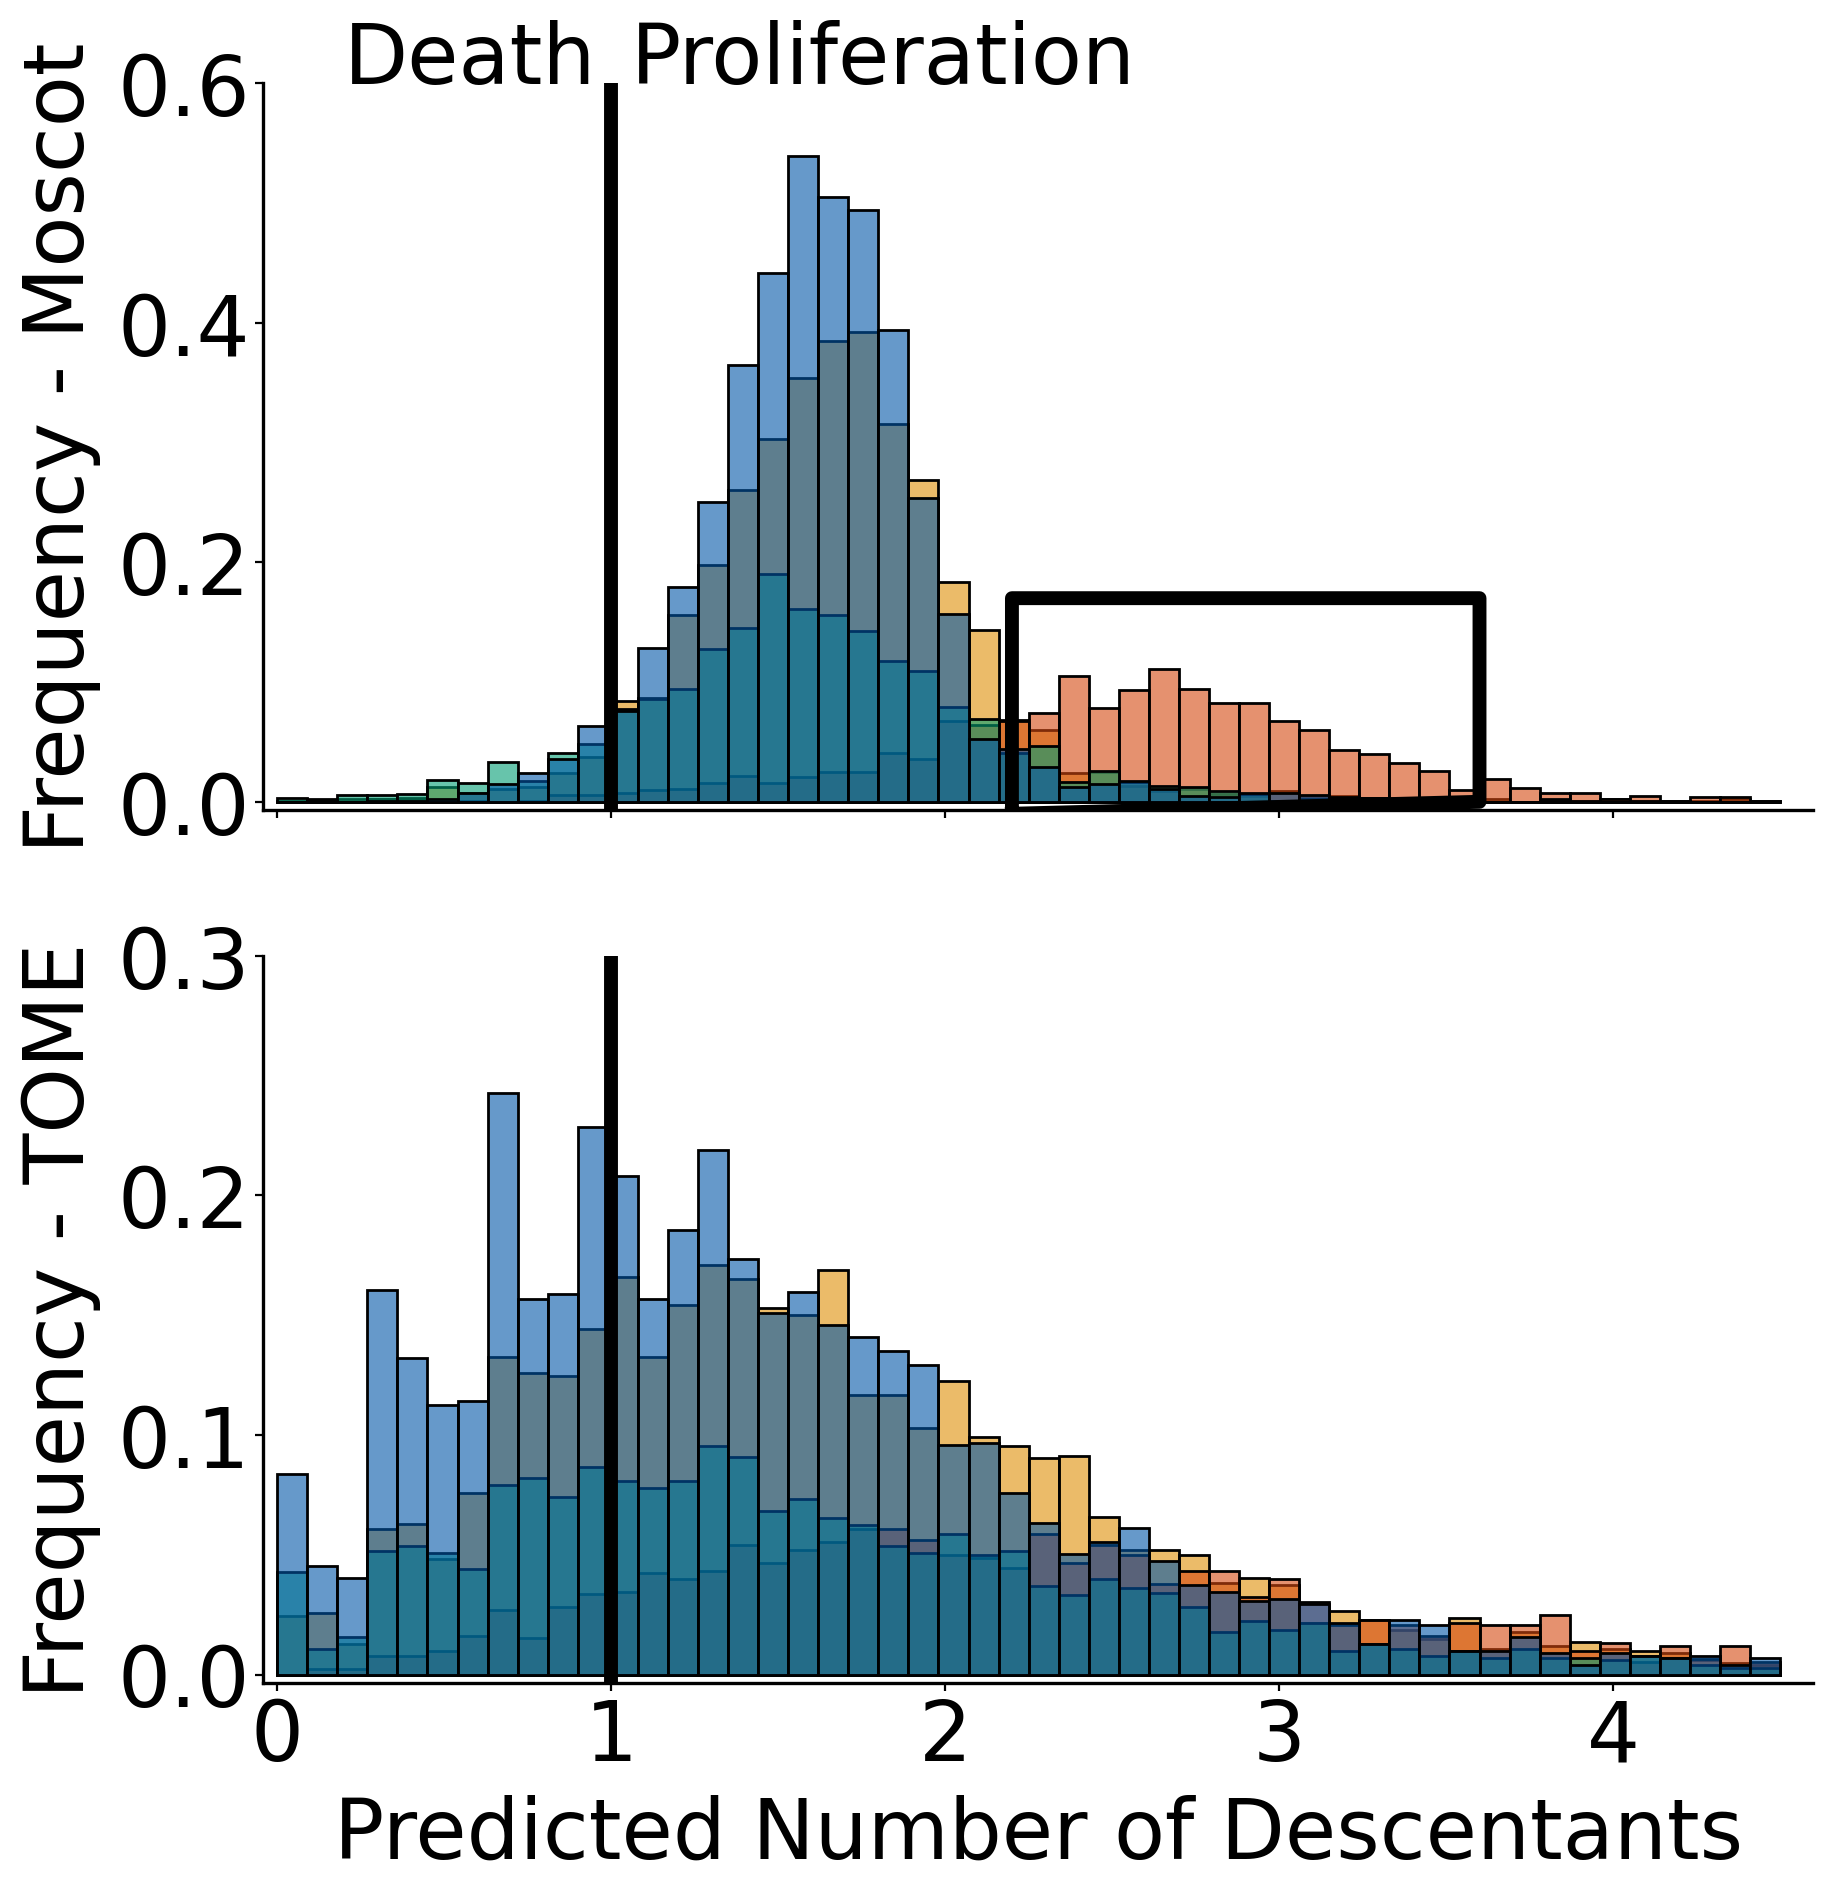

In [15]:
fontsize=30

xlim=4.5
alpha=0.6
linewidth=5

xl=2.2
xr=3.6


plt.figure(figsize = [10, 8], dpi=200)

plt.subplot(2, 1, 1) # 1 row, 2 cols, subplot 1

plt.subplots_adjust(bottom=0, top=1, hspace=0.2)

g1=sns.histplot(data=dfms, x='Predicted Number of Descentants', hue='Cell type', bins=np.linspace(0,xlim,51), 
                palette=pal,alpha=alpha, legend=False, stat='density')
g1.set(xticklabels=[])
g1.set(xlabel=None)
g1.tick_params(axis='both', which='major', labelsize=fontsize)

ylabel_name='Frequency'
plt.plot([xl,xr,xr,xl,xl], [-0.01,0,0.17,0.17,-0.01], color='black', linestyle='solid', linewidth=linewidth)

plt.ylabel(ylabel_name+ ' - Moscot', fontsize=fontsize)

ylim_t=0.3
ylim_m=0.6


plt.ylim(-ylim_m*0.012,ylim_m)
plt.xlim(-0.01*4.1,xlim+0.1)

#plt.text(x=-0.8,y=145,s='TOME', rotation='vertical', color=pal[1], fontsize=20, weight="bold")
plt.text(x=1.06,y=ylim_m*1.0,s='Proliferation', color='black', fontsize=fontsize)
plt.text(x=0.2,y=ylim_m*1.0,s='Death', color='black', fontsize=fontsize)


plt.plot([1,1], [-0.1,1], color='black', linestyle='solid',linewidth=linewidth)

plt.subplot(2, 1, 2) # 1 row, 2 cols, subplot 2
g2=sns.histplot(data=dfts, x='Predicted Number of Descentants', hue='Cell type',
                bins=np.linspace(0,xlim,51), palette=pal,alpha=alpha,stat='density', legend=False)

plt.ylabel(ylabel_name+ ' - TOME', fontsize=fontsize)
plt.xlabel('Predicted Number of Descentants', fontsize=fontsize)


#plt.text(x=-1.2,y=255,s='Moscot', rotation='vertical', color='black', fontsize=fontsize+2, weight="bold")
#plt.text(x=2.95, y=ylim_m*0.8,s='Moscot', color='black', fontsize=fontsize+4, weight="bold")


g2.tick_params(axis='both', which='major', labelsize=fontsize)

plt.ylim(-ylim_t*0.012,ylim_t)
plt.xlim(-0.01*4.1,xlim+0.1)

xl=2.2
xr=4

#plt.text(x=-0.2, y=0.73, s='Growth rates: E7.0 to E7.25', color='black', fontsize=fontsize+4, weight="bold")
plt.plot([1,1], [-0.1,1], color='black', linestyle='solid',linewidth=linewidth)

#sns.move_legend(obj=g2, loc=(1.03,0.6), ncol=1, title_fontsize=fontsize, title_weight='bold', fontsize=fontsize,
#               fancybox=True, frameon=True)

#sns.move_legend(obj=g2, loc=(1.03,0.55), ncol=1, title_fontsize=fontsize, title_weight='bold', fontsize=fontsize)

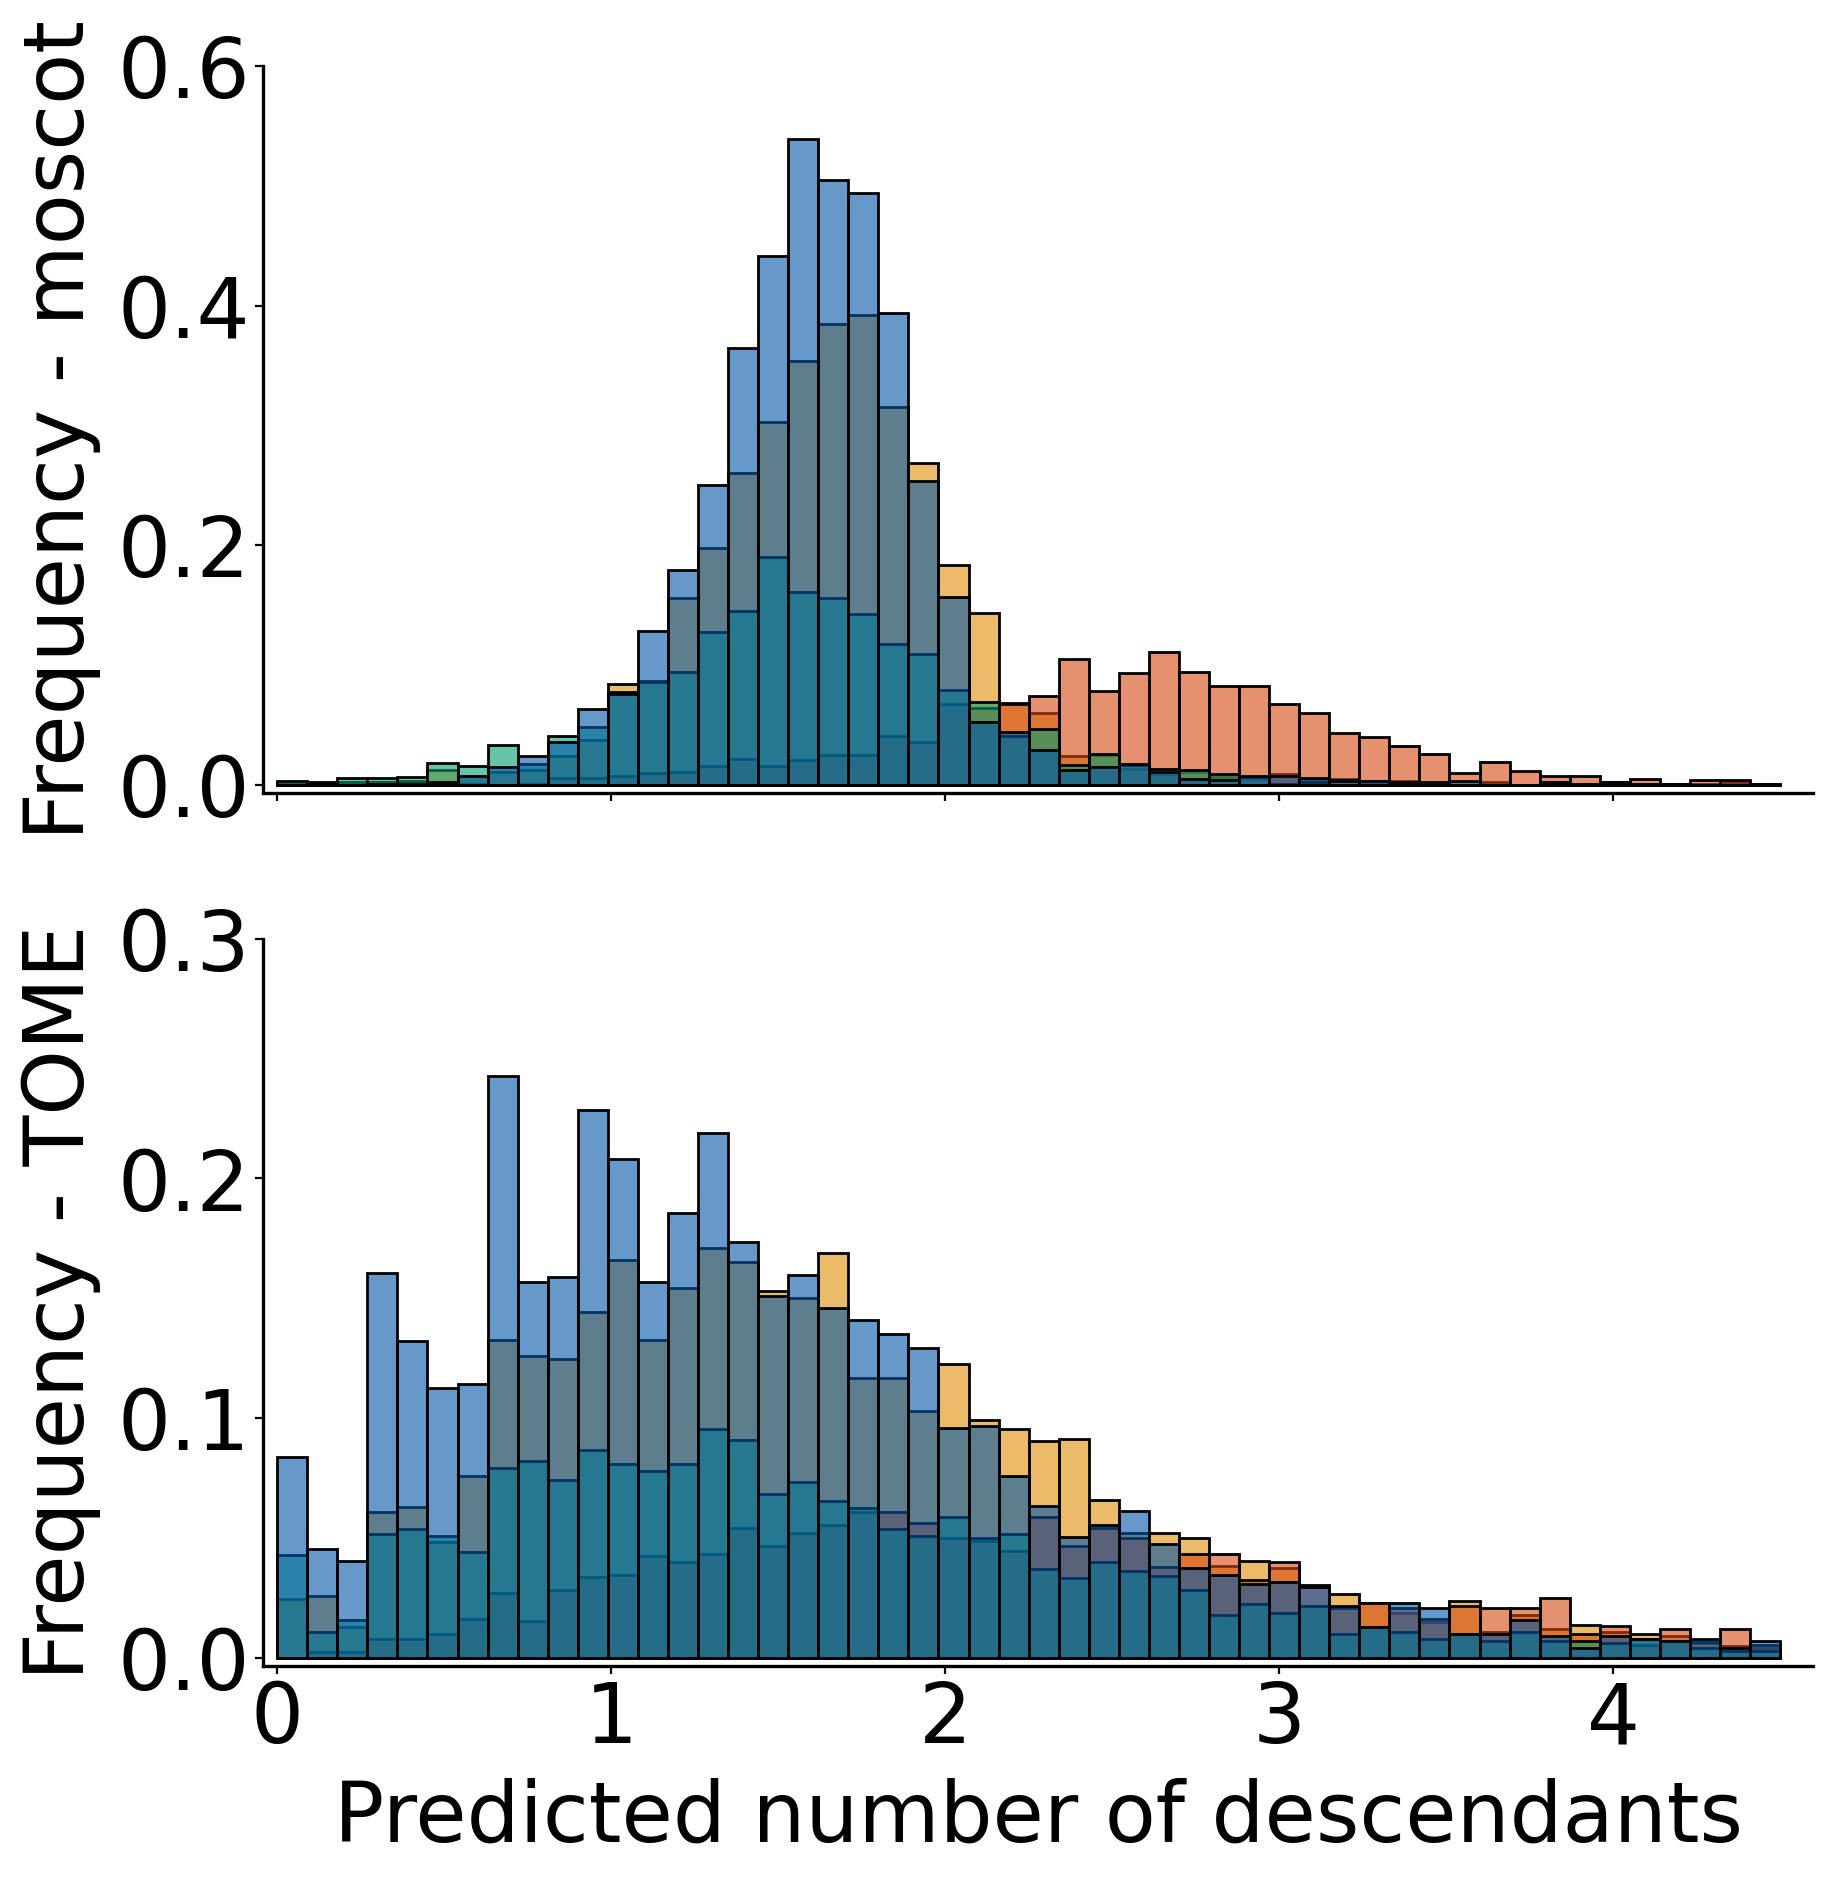

In [18]:
fontsize=30
linewidth=5

xlim=4.5
alpha=0.6

plt.figure(figsize = [10, 8], dpi=200)

plt.subplot(2, 1, 1) # 1 row, 2 cols, subplot 1

plt.subplots_adjust(bottom=0, top=1, hspace=0.2)

g1=sns.histplot(data=dfms, x='Predicted Number of Descentants', hue='Cell type', bins=np.linspace(0,xlim,51), 
                palette=pal,alpha=alpha, legend=False, stat='density')
g1.set(xticklabels=[])
g1.set(xlabel=None)
g1.tick_params(axis='both', which='major', labelsize=fontsize)

ylabel_name='Frequency'
#plt.plot([xl,xr,xr,xl,xl], [-0.01,0,0.17,0.17,-0.01], color='black', linestyle='solid', linewidth=linewidth)

plt.ylabel(ylabel_name+ ' - moscot', fontsize=fontsize)

ylim_t=0.3
ylim_m=0.6


plt.ylim(-ylim_m*0.012,ylim_m)
plt.xlim(-0.01*4.1,xlim+0.1)

#plt.text(x=-0.8,y=145,s='TOME', rotation='vertical', color=pal[1], fontsize=20, weight="bold")
#plt.text(x=1.06,y=ylim_m*1.0,s='Proliferation', color='black', fontsize=fontsize)
#plt.text(x=0.18,y=ylim_m*1.0,s='Death', color='black', fontsize=fontsize)


#plt.plot([1,1], [-0.1,1], color='black', linestyle='solid',linewidth=linewidth)

plt.subplot(2, 1, 2) # 1 row, 2 cols, subplot 2
g2=sns.histplot(data=dfts, x='Predicted Number of Descentants', hue='Cell type',
                bins=np.linspace(0,xlim,51), palette=pal,alpha=alpha,stat='density', legend=False)

plt.ylabel(ylabel_name+ ' - TOME', fontsize=fontsize)
plt.xlabel('Predicted number of descendants', fontsize=fontsize)


#plt.text(x=-1.2,y=255,s='Moscot', rotation='vertical', color='black', fontsize=fontsize+2, weight="bold")
#plt.text(x=2.95, y=ylim_m*0.8,s='Moscot', color='black', fontsize=fontsize+4, weight="bold")


g2.tick_params(axis='both', which='major', labelsize=fontsize)

plt.ylim(-ylim_t*0.012,ylim_t)
plt.xlim(-0.01*4.1,xlim+0.1)

xl=2.2
xr=4

#plt.text(x=-0.2, y=0.73, s='Growth rates: E7.0 to E7.25', color='black', fontsize=fontsize+4, weight="bold")
#plt.plot([1,1], [-0.1,1], color='black', linestyle='solid',linewidth=linewidth)

#sns.move_legend(obj=g2, loc=(1.03,0.6), ncol=1, title_fontsize=fontsize, title_weight='bold', fontsize=fontsize,
#               fancybox=True, frameon=True)

#sns.move_legend(obj=g2, loc=(1.03,0.55), ncol=1, title_fontsize=fontsize, title_weight='bold', fontsize=fontsize)